In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ktrain
from ktrain import tabular
import os
import glob
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
def read_and_combine(mode="training",drop=""):
    if mode=="training":
        all_files = glob.glob(os.path.join("./training_data", "*.csv"))
        df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
        if drop!=None:
            if isinstance(drop,list):
                for x in drop:
                    cols.remove(x)
            else:
                cols.remove(drop)
        return df.loc[:,cols]
    elif mode=="testing":
        all_files = glob.glob(os.path.join("./testing_data", "*.csv"))
        df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
        if drop!=None:
            if isinstance(drop,list):
                for x in drop:
                    cols.remove(x)
            else:
                cols.remove(drop)
        return df.loc[:,cols]
    
def read_hardware(drop=None):
    all_files = glob.glob(os.path.join("./real_circuits_hardware/", "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
    if drop!=None:
        if isinstance(drop,list):
            for x in drop:
                cols.remove(x)
        else:
            cols.remove(drop)
    return df.loc[:,cols]

def read_program(program_name,backend,drop=None):
    all_files = glob.glob(os.path.join("./real_circuits_hardware/", "*.csv"))
    for file in all_files:
        if program_name in file and backend.name in file:
            df = pd.read_csv(file)
            cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]            
            if drop!=None:
                if isinstance(drop,list):
                    for x in drop:
                        cols.remove(x)
                else:
                    cols.remove(drop)
            return df.loc[:,cols]
        
def HellingerDistance(p, q):
    q[q<0] = 0
    p = p/100
    q = q/100
    n = len(p)
    sum_ = 0.0
    for i in range(n):
        sum_ += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum_)
    return result

def get_program_dict():
    program = {}
    for file in os.listdir("./real_circuits"):
        name = file.split("_")[0]
        program[name] = {"name":name,"mlp":0}
    return program

from qiskit_ibm_provider import IBMProvider
with open("API_KEY.txt","r") as file:
    key = file.read()
provider = IBMProvider(token=key)
def filters(x):
    if "simulator" not in x.name:
        return x
backends = provider.backends(filters=filters)
backends = sorted(backends,key=lambda x: x.name)
backends

[<IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_quito')>]

# Original vs NEW

In [3]:
with open("feature_value","rb") as file:
    feature_value = pickle.load(file)
    
with open("mlp_10_runs","rb") as file:
    base_value = pickle.load(file)

In [4]:
temp = pd.DataFrame(columns=feature_value.keys())
for feature in feature_value:
    index = 0
    for cp in feature_value[feature]:
        value = np.mean(feature_value[feature][cp])
        temp.loc[index,feature] = value
        index+=1
mapper = {"circuit_depth":"$Cd$","circuit_width":"$Cw$","observed_prob_50":"$Prob_{obv}$",
          "Avg_odds_ratio":"$Odr$","Avg_inverted_error_25":"$Dpe_{1/4}$","Avg_inverted_error_50":"$Dpe_{1/2}$",
          "Avg_inverted_error_75":"$Dpe_{3/4}$","state_weight":"$Stw$","Num_1Q_Gates":"$Gc_{1q}$","Num_2Q_Gates":"$Gc_{2q}$"}
importances = temp.rename(columns=mapper).astype(float)

In [5]:
importances.median()

$Dpe_{1/4}$     0.543938
$Dpe_{1/2}$     0.557525
$Dpe_{3/4}$     0.553991
$Odr$           0.562761
$Gc_{1q}$       0.576520
$Gc_{2q}$       0.580128
$Cd$            0.584138
$Cw$            0.558904
$Prob_{obv}$    0.717225
$Stw$           0.541910
dtype: float64

In [6]:
base_importances = importances.copy()
values = []
for x in base_value:
    values.append(np.mean(base_value[x]))

for x in base_importances.columns:
    base_importances.loc[:,x] = values

base_importances = base_importances.astype(float)

In [7]:
base_importances.median()

$Dpe_{1/4}$     0.517
$Dpe_{1/2}$     0.517
$Dpe_{3/4}$     0.517
$Odr$           0.517
$Gc_{1q}$       0.517
$Gc_{2q}$       0.517
$Cd$            0.517
$Cw$            0.517
$Prob_{obv}$    0.517
$Stw$           0.517
dtype: float64

In [8]:
data = pd.DataFrame(columns=["Feature","outputerror","kind"])
new_index = 0
for feature in base_importances.columns:
    for index in base_importances.index:
        data.loc[new_index] = [feature,np.round(base_importances.loc[index,feature],2),"FULL"]
        new_index+=1

for feature in importances.columns:
    for index in importances.index:
        data.loc[new_index] = [feature,importances.loc[index,feature],"LOCO"]
        new_index+=1

In [9]:
data

,Feature,outputerror,kind
0,$Dpe_{1/4}$,0.520000,FULL
1,$Dpe_{1/4}$,0.610000,FULL
2,$Dpe_{1/4}$,0.560000,FULL
3,$Dpe_{1/4}$,0.590000,FULL
4,$Dpe_{1/4}$,0.030000,FULL
...,...,...,...
955,$Stw$,0.712755,LOCO
956,$Stw$,0.645687,LOCO
957,$Stw$,0.503662,LOCO
958,$Stw$,0.214350,LOCO


In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11,4)})
sns.set_theme(style='white')

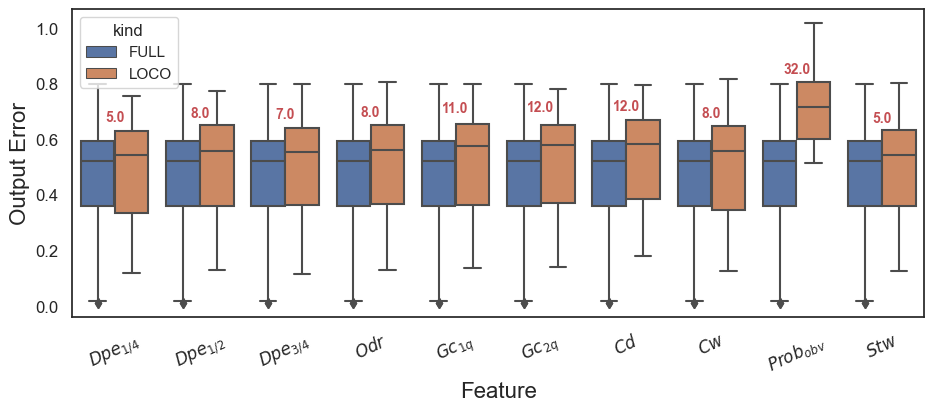

In [11]:
ax = sns.boxplot(data,x="Feature", y="outputerror",hue="kind")
plt.xlabel('Feature', fontsize=16);
plt.ylabel('Output Error', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=25)

for i, label in enumerate(ax.get_xticklabels()):
    v1 = base_importances.median()[label.get_text()]
    v2 = importances.median()[label.get_text()]
    diff = np.round((np.abs(v1-v2)/((v1+v2)/2))*100)
    ax.text(i,
            importances.median()[label.get_text()] + 0.12,
            diff,
            horizontalalignment='center',
            size='small',
            color='r',
            weight='semibold')

plt.savefig("importance_lofo.png",bbox_inches="tight",dpi=600)

# Statistical Test

In [12]:
with open("feature_value","rb") as file:
    feature_value = pickle.load(file)
    
with open("mlp_10_runs","rb") as file:
    base_value = pickle.load(file)

In [13]:
temp = pd.DataFrame(columns=feature_value.keys())
for feature in feature_value:
    index = 0
    for cp in feature_value[feature]:
        value = feature_value[feature][cp]
        temp.loc[index,feature] = value
        index+=1
temp

,Avg_inverted_error_25,Avg_inverted_error_50,Avg_inverted_error_75,Avg_odds_ratio,Num_1Q_Gates,Num_2Q_Gates,circuit_depth,circuit_width,observed_prob_50,state_weight
0,"[0.5289321, 0.53807026, 0.5528775, 0.54769355,...","[0.5365635, 0.5450115, 0.53823143, 0.5363234, ...","[0.55768234, 0.5575805, 0.58416754, 0.5850094,...","[0.54227126, 0.5422408, 0.51774734, 0.54777586...","[0.50967467, 0.5357698, 0.54379934, 0.53841394...","[0.54598874, 0.561048, 0.551909, 0.5841824, 0....","[0.6211898, 0.60438585, 0.5424903, 0.5407948, ...","[0.53858936, 0.5462452, 0.5260708, 0.5385547, ...","[0.62332463, 0.5964152, 0.6345806, 0.70466113,...","[0.5165083, 0.53736967, 0.5208542, 0.5478966, ..."
1,"[0.6133801, 0.68031913, 0.6811041, 0.6814771, ...","[0.66158295, 0.6921272, 0.6946009, 0.70689505,...","[0.6829997, 0.7707938, 0.7203931, 0.7309726, 0...","[0.7598897, 0.77477676, 0.7356765, 0.7234356, ...","[0.7371308, 0.71065074, 0.83805805, 0.7504962,...","[0.7031179, 0.7246306, 0.7023087, 0.77173287, ...","[0.718054, 0.8781734, 0.7140633, 0.6890955, 0....","[0.6993788, 0.7570987, 0.6988534, 0.72119725, ...","[0.74889916, 0.7266939, 0.72185826, 0.7143895,...","[0.73331714, 0.7089898, 0.7391566, 0.6950746, ..."
2,"[0.5527832, 0.60874957, 0.6455462, 0.6477953, ...","[0.66986495, 0.79886144, 0.60931176, 0.7070552...","[0.6710758, 0.6481495, 0.7148569, 0.6664918, 0...","[0.6116444, 0.7020353, 0.6671606, 0.66053647, ...","[0.68881935, 0.68257636, 0.68480694, 0.6046663...","[0.60307395, 0.7137105, 0.7202997, 0.69987166,...","[0.69769835, 0.8861346, 0.6850923, 0.61571044,...","[0.6584625, 0.69487965, 0.64839226, 0.69252324...","[0.83631027, 0.9850345, 1.246879, 0.81579685, ...","[0.5581617, 0.6217123, 0.6249665, 0.5806353, 0..."
3,"[0.59550536, 0.6157713, 0.62319803, 0.6136793,...","[0.61876845, 0.64808923, 0.6127758, 0.65108365...","[0.61780936, 0.6085487, 0.64061725, 0.62606543...","[0.58469063, 0.6484674, 0.61610276, 0.60745674...","[0.6148584, 0.62304604, 0.6267648, 0.62222064,...","[0.6164877, 0.6648622, 0.6279219, 0.65068835, ...","[0.68601465, 0.750875, 0.6389592, 0.6075741, 0...","[0.597767, 0.6335609, 0.5981046, 0.62009525, 0...","[0.6972579, 0.7620796, 0.77764064, 0.897739, 0...","[0.6050975, 0.6375664, 0.6240119, 0.6229972, 0..."
4,"[0.05924304, 0.11530831, 0.12932307, 0.0995876...","[0.12417301, 0.17918865, 0.08165053, 0.1792115...","[0.10765623, 0.089772195, 0.16408993, 0.149708...","[0.0917707, 0.17546286, 0.07976295, 0.0578825,...","[0.12695596, 0.1519754, 0.1612557, 0.0817543, ...","[0.075506486, 0.1841452, 0.1417573, 0.17772797...","[0.1946268, 0.61428994, 0.16485217, 0.07140572...","[0.09318024, 0.17896853, 0.1148957, 0.15898472...","[0.53410465, 0.5187007, 0.5179145, 0.53366184,...","[0.073298566, 0.16909002, 0.060070526, 0.14008..."
5,"[0.41159934, 0.37805474, 0.38061664, 0.4038449...","[0.40446502, 0.43118033, 0.41179484, 0.4105450...","[0.3845723, 0.3779879, 0.4055251, 0.39163402, ...","[0.3732328, 0.42466223, 0.3993115, 0.37224352,...","[0.3942863, 0.39711094, 0.38658658, 0.3901422,...","[0.42483386, 0.41547078, 0.40117258, 0.4173869...","[0.5278698, 0.56545925, 0.40216017, 0.37407008...","[0.38331142, 0.3890311, 0.384304, 0.3943903, 0...","[0.6154816, 0.57519597, 0.5310884, 0.6134698, ...","[0.39712226, 0.40458432, 0.40392855, 0.3907940..."
6,"[0.5251267, 0.46685356, 0.57744056, 0.5099981,...","[0.4117813, 0.42114952, 0.43350354, 0.38687718...","[0.42713434, 0.45968196, 0.5029864, 0.39963463...","[0.45000982, 0.4240534, 0.41036656, 0.43486494...","[0.43324253, 0.45102257, 0.4180459, 0.46982858...","[0.4124155, 0.44210568, 0.49584845, 0.40093583...","[0.4178177, 0.6082652, 0.47306937, 0.4314923, ...","[0.44402826, 0.43187627, 0.43778977, 0.3741220...","[0.58646935, 0.5669421, 0.56906646, 0.5997718,...","[0.46375135, 0.4479072, 0.4342413, 0.4331476, ..."
7,"[0.53428113, 0.6377109, 0.6527027, 0.6375753, ...","[0.59638584, 0.67784476, 0.7334458, 0.66643953...","[0.6045987, 0.6776207, 0.626928, 0.62007123, 0...","[0.7377244, 0.6933155

In [14]:
baseline = pd.DataFrame(columns=["Baseline"])
index = 0
for cp in base_value:
    value = base_value[cp]
    baseline.loc[index,"Baseline"] = value
    index+=1

In [15]:
import numpy as np
import rpy2.robjects as robjects
import scipy.stats as stats
r = robjects.r
r.library('effsize')
r['source']('A12.R')
A12 = robjects.globalenv['A12']

manwhitney_result = temp.copy()

def styler(x):
    if isinstance(x,tuple):
        return "background-color: white"
    else:
        if x<0.05:
            return "background-color: green"
        else:
            "background-color: white"
        

for feature in temp.columns:
    for index in temp.index:
        A = temp.loc[index,feature]
        B = baseline.loc[index,"Baseline"]
        pvalue = stats.mannwhitneyu(A, B).pvalue
        manwhitney_result.loc[index,feature] = pvalue


index = []
for x in base_value:
    index.append(x)
manwhitney_result["index"] = index
manwhitney_result.set_index("index",inplace=True)
mapper = {"circuit_depth":"$Cd$","circuit_width":"$Cw$","observed_prob_50":"$prob_{obv}$",
          "Avg_odds_ratio":"$Odr$","Avg_inverted_error_25":"$Dpe_{1/4}$","Avg_inverted_error_50":"$Dpe_{1/2}$",
          "Avg_inverted_error_75":"$Dpe_{3/4}$","state_weight":"$Stw$","Num_1Q_Gates":"$Gc_{1q}$","Num_2Q_Gates":"$Gc_{2q}$"}
manwhitney_result = manwhitney_result.rename(columns=mapper)
manwhitney_result.style.applymap(styler).to_excel('statistical_test.xlsx')
#manwhitney_result.style.applymap(styler).to_latex()
manwhitney_result.style.applymap(styler)

,$Dpe_{1/4}$,$Dpe_{1/2}$,$Dpe_{3/4}$,$Odr$,$Gc_{1q}$,$Gc_{2q}$,$Cd$,$Cw$,$prob_{obv}$,$Stw$
index,,,,,,,,,,
"('ibm_lagos', 'groundstate')",0.005416,0.013272,0.006831,0.024589,0.073353,0.000395,0.002614,0.020125,0.000162,0.061926
"('ibm_lagos', 'pricingcall')",0.017174,0.000326,0.000577,0.000762,0.000181,0.000577,0.001693,0.000326,0.000181,0.000577
"('ibm_lagos', 'pricingput')",0.001612,0.000545,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.001612
"('ibm_lagos', 'qaoa')",0.001508,0.000154,0.000503,0.001957,0.000154,0.000154,0.000503,0.024097,0.000154,0.000154
"('ibm_lagos', 'routing')",0.000087,0.001329,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087
"('ibm_lagos', 'tsp')",0.053092,0.160550,0.621995,0.676551,0.343066,0.790644,0.969747,0.016882,0.000174,0.676551
"('ibm_nairobi', 'groundstate')",0.000231,0.007023,0.087531,0.909314,0.183886,0.036776,0.518630,0.621599,0.000171,0.062824
"('ibm_nairobi', 'pricingcall')",0.002169,0.000572,0.000431,0.000990,0.000179,0.000179,0.000431,0.000572,0.000179,0.002169
"('ibm_nairobi', 'pricingput')",0.001298,0.000242,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.001298


In [16]:
(((manwhitney_result<0.05).sum()/manwhitney_result.shape[0])*100).round()

$Dpe_{1/4}$     71.0
$Dpe_{1/2}$     71.0
$Dpe_{3/4}$     62.0
$Odr$           58.0
$Gc_{1q}$       75.0
$Gc_{2q}$       69.0
$Cd$            60.0
$Cw$            75.0
$prob_{obv}$    88.0
$Stw$           62.0
dtype: float64

In [17]:
sum([True for i in range(manwhitney_result.shape[0]) if (manwhitney_result.iloc[i,:]<0.05).sum()==10])

23

In [18]:
A12_result = temp.copy()

def styler(x):
    if isinstance(x,tuple):
        return "background-color: white"
    else:
        if x<0.05:
            return "background-color: green"
        else:
            "background-color: white"
        

for feature in temp.columns:
    for index in temp.index:
        A = temp.loc[index,feature]
        B = baseline.loc[index,"Baseline"]
        pvalue = stats.mannwhitneyu(A, B).pvalue
        if pvalue<0.05:
            df_result_r = A12(robjects.FloatVector(A),robjects.FloatVector(B))
            mag = str(df_result_r[2]).split("\n")[0].split()[-1]
            effect = float(str(df_result_r[3]).split()[-1])
            effect = 1-effect
        
            A12_result.loc[index,feature] = mag
        else:
            A12_result.loc[index,feature] = "low"

mapper = {"circuit_depth":"$Cd$","circuit_width":"$Cw$","observed_prob_50":"$prob_{obv}$",
          "Avg_odds_ratio":"$Odr$","Avg_inverted_error_25":"$Dpe_{1/4}$","Avg_inverted_error_50":"$Dpe_{1/2}$",
          "Avg_inverted_error_75":"$Dpe_{3/4}$","state_weight":"$Stw$","Num_1Q_Gates":"$Gc_{1q}$","Num_2Q_Gates":"$Gc_{2q}$"}
A12_result = A12_result.rename(columns=mapper)
A12_result.to_excel('A12_test.xlsx')
A12_result

,$Dpe_{1/4}$,$Dpe_{1/2}$,$Dpe_{3/4}$,$Odr$,$Gc_{1q}$,$Gc_{2q}$,$Cd$,$Cw$,$prob_{obv}$,$Stw$
0,large,large,large,large,low,large,large,large,large,low
1,large,large,large,large,large,large,large,large,large,large
2,large,large,large,large,large,large,large,large,large,large
3,large,large,large,large,large,large,large,large,large,large
4,large,large,large,large,large,large,large,large,large,large
5,low,low,low,low,low,low,low,large,large,low
6,large,large,low,low,low,large,low,low,large,low
7,large,large,large,large,large,large,large,large,large,large
8,large,large,large,large,large,large,large,large,large,large
9,low,low,low,low,low,low,low,large,large,low


In [19]:
(((A12_result=="large").sum()/A12_result.shape[0])*100).round()

$Dpe_{1/4}$     71.0
$Dpe_{1/2}$     71.0
$Dpe_{3/4}$     62.0
$Odr$           58.0
$Gc_{1q}$       75.0
$Gc_{2q}$       69.0
$Cd$            60.0
$Cw$            75.0
$prob_{obv}$    88.0
$Stw$           62.0
dtype: float64